In [1]:
%cd ..


/Users/eliaweiss/ai/segmentation/MobileSAM


In [2]:
import cv2
import numpy as np
from tblDetect.TableDetect import TableDetect
from tblDetect.MobileSamBoxes import MobileSamBoxes
import matplotlib.pyplot as plt
from PIL import Image
from notebooks.Utils import plot_results, plot_annotations, \
    plot_rotatedResult,outputs_to_objects, \
        calculate_angle

/Users/eliaweiss/ai/segmentation/MobileSAM/tinyvit/tiny_vit.py:656: UserWarning: Overwriting tiny_vit_5m_224 in registry with tinyvit.tiny_vit.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/Users/eliaweiss/ai/segmentation/MobileSAM/tinyvit/tiny_vit.py:656: UserWarning: Overwriting tiny_vit_11m_224 in registry with tinyvit.tiny_vit.tiny_vit_11m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/Users/eliaweiss/ai/segmentation/MobileSAM/tinyvit/tiny_vit.py:656: UserWarning: Overwriting tiny_vit_21m_224 in registry with tinyvit.tiny_vit.tiny_vit_21m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/Users/eliaweiss/ai/segmentation/MobileSAM/tinyvit/tiny_vit.py:656: U

In [3]:
# file_path = "./app/assets/picture1.jpg"
# file_path = "/Users/eliaweiss/Documents/doc2txt/sihach/attachments/img/20231025012642_001.jpg"
file_path = "/Users/eliaweiss/Documents/doc2txt/sihach/need fix/4e7d4235deff4ee2b72d886e12ad0bcf.jpg"
# file_path = "/Users/eliaweiss/Documents/doc2txt/invoices 2/expense (6).jpeg"
file_path = "/Users/eliaweiss/Documents/doc2txt/lineCv/1/12.png"

img = Image.open(file_path)
max_size = (1000, 1000)  # Example maximum size

# Resize the image
img.thumbnail(max_size)

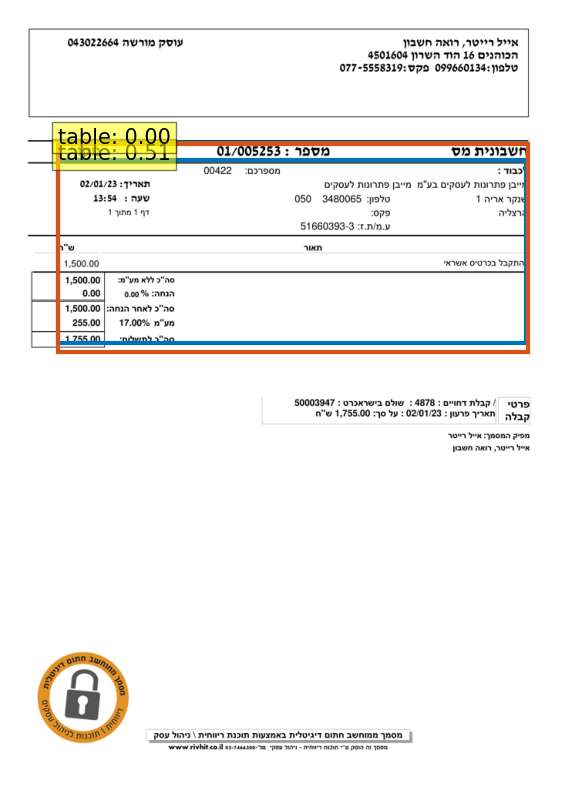

In [150]:
tblDec = TableDetect()
probas, boxes = tblDec.detectTables(img)
plot_results(tblDec.model, img, probas, boxes)


# Crop table with sam

checkpoint_load_scucess
shape (1000, 707, 3)
------ total time: (s): 2.08


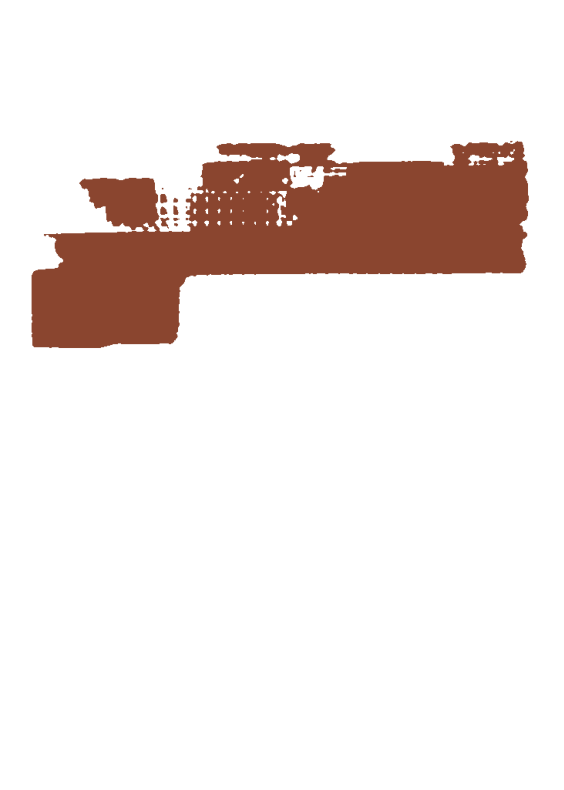

In [5]:
sam = MobileSamBoxes()
anns = sam.process(img,boxes)
plot_annotations(img, anns)

In [43]:
len(anns)

2

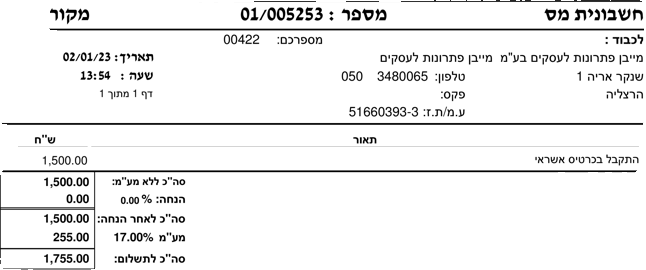

In [44]:
from PIL import Image
import cv2

def create_mask_patch(image, mask):
  """
  Creates a patch from the image containing only the mask region.

  Args:
      image: A PIL image object.
      mask: A NumPy array representing the mask (1 for mask pixels).

  Returns:
      A PIL image object containing the patch from the original image 
      with only the mask region and white background for non-mask pixels.
  """
  mask=mask.cpu().numpy()
  # mask = cv2.dilate(mask, np.ones((13, 13), np.uint8), iterations=1)  
  # Find non-zero elements (mask pixels) in the mask
  mask_coords = np.where(mask != 0)

  # Get minimum and maximum coordinates from the mask pixels
  min_y, min_x = mask_coords[0].min(), mask_coords[1].min()
  max_y, max_x = mask_coords[0].max() + 1, mask_coords[1].max() + 1  # Add 1 for inclusive range

  # Create the bounding box rectangle
  bounding_box = (min_x, min_y, max_x, max_y)


  mask = mask==1
  imgArr = np.array(image)
  imgArr[~mask] = (255,255,255)
  image = Image.fromarray(imgArr)
  # color_mask = np.concatenate([np.random.random(3), [1]])
  # img[m] = color_mask
  # Crop the image using the bounding box
  patch_image = image.crop(bounding_box)
  return patch_image

# Example usage
mask = anns[1]

tbl_patch = create_mask_patch(img, mask)
# patch.show()  # Display the created patch
tbl_patch


# Table structure recognition

In [45]:
from transformers import DetrFeatureExtractor

feature_extractor = DetrFeatureExtractor()
encoding = feature_extractor(tbl_patch, return_tensors="pt")
encoding.keys()

/Users/eliaweiss/opt/anaconda3/envs/mobileSam/lib/python3.10/site-packages/transformers/models/detr/feature_extraction_detr.py:38: FutureWarning: The class DetrFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DetrImageProcessor instead.
  warnings.warn(


dict_keys(['pixel_values', 'pixel_mask'])

In [46]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

In [47]:
from transformers import TableTransformerForObjectDetection

# new v1.1 checkpoints require no timm anymore
structure_model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-structure-recognition-v1.1-all")
structure_model.to(device)
""

''

In [48]:
from torchvision import transforms

class MaxResize(object):
    def __init__(self, max_size=800):
        self.max_size = max_size

    def __call__(self, image):
        width, height = image.size
        current_max_size = max(width, height)
        scale = self.max_size / current_max_size
        resized_image = image.resize((int(round(scale*width)), int(round(scale*height))))

        return resized_image
structure_transform = transforms.Compose([
    MaxResize(1000),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [49]:
def plot_results_cells(tbl_patch, cells, class_to_visualize):
    if class_to_visualize not in structure_model.config.id2label.values():
      raise ValueError(f"Class should be one of the available classes {structure_model.config.id2label}")

    plt.figure(figsize=(16,10))
    plt.imshow(tbl_patch)
    ax = plt.gca()

    for cell in cells:
        bbox = cell["bbox"]
        label = cell["label"]

        if label == class_to_visualize:
          xmin, ymin, xmax, ymax = tuple(bbox)

          ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color=np.random.random(3), linewidth=3))
          plt.axis('off')

# align table

In [151]:
m = anns[0].bool()
m=m.cpu().numpy()
mask = np.zeros((anns.shape[1], anns.shape[2], 1), np.uint8)
mask[m] = 255
# mask = ~mask
print(mask.shape)
print(mask.dtype)

(1000, 707, 1)
uint8


In [152]:
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contour = None
rectArea = None
for c in contours:
    _,_,h,w =cv2.boundingRect(c)
    if rectArea is None or rectArea < h*w:
        rectArea = h*w
        contour = c
        
    print(h*w)
rectArea  
# len(contours)

20
32
180
6
99
84
36
108
10
4
173505
6


173505

In [153]:
image = np.array(img)

In [154]:
def calcBB():
    mask_coords = np.where(mask != 0)

# Get minimum and maximum coordinates from the mask pixels
    min_y, min_x = mask_coords[0].min(), mask_coords[1].min()
    max_y, max_x = mask_coords[0].max() + 1, mask_coords[1].max() + 1  # Add 1 for inclusive range

# Define the dimensions of the output rectangle
    width = max_x-min_x  # Define your desired width here
    height = max_y-min_y  # Define your desired height here
    return (min_x, max_x), (min_y, max_y), (width,height)



In [155]:
def linear_interpolation_midpoint(p1,p2):
  (x1, y1) = p1
  (x2, y2) = p2
  # Calculate the slopes in x and y directions
  slope_x = (x2 - x1) / 2
  slope_y = (y2 - y1) / 2

  # Calculate the midpoint coordinates
  midpoint_x = x1 + slope_x
  midpoint_y = y1 + slope_y

  return midpoint_x, midpoint_y

In [156]:
def find_closest_point_in_contour(contour, point_xy):
   min_dist = np.inf
   closest_point = None

   for contour_point in contour:
       x, y = contour_point[0]
       dist = np.sqrt((x - point_xy[0])**2 + (y - point_xy[1])**2)
       if dist < min_dist:
           min_dist = dist
           closest_point = x, y

   return closest_point
#    return linear_interpolation_midpoint(closest_point,point_xy)

def approxBoundingQuadrilateral(find_closest_point_in_contour):
    (min_x, max_x), (min_y, max_y), (width,height) = calcBB()
    lb = find_closest_point_in_contour(contour, (min_x,min_y))
    lt = find_closest_point_in_contour(contour, (min_x,max_y))
    rt = find_closest_point_in_contour(contour, (max_x,max_y))
    rb = find_closest_point_in_contour(contour, (max_x,min_y))
    # return clock wise
    return (lb,rb, rt, lt), (width,height)

boundingQuadrilateral, (width,height) = approxBoundingQuadrilateral(find_closest_point_in_contour)
boundingQuadrilateral

((90, 224), (664, 172), (662, 341), (31, 437))

In [157]:
(min_x, max_x), (min_y, max_y), (width,height) = calcBB()


In [158]:
print((min_x,min_y))
find_closest_point_in_contour(contour, (min_x,min_y))

(28, 170)


(90, 224)

In [159]:
print((max_x,min_y))
find_closest_point_in_contour(contour, (max_x,min_y))

(673, 170)


(664, 172)

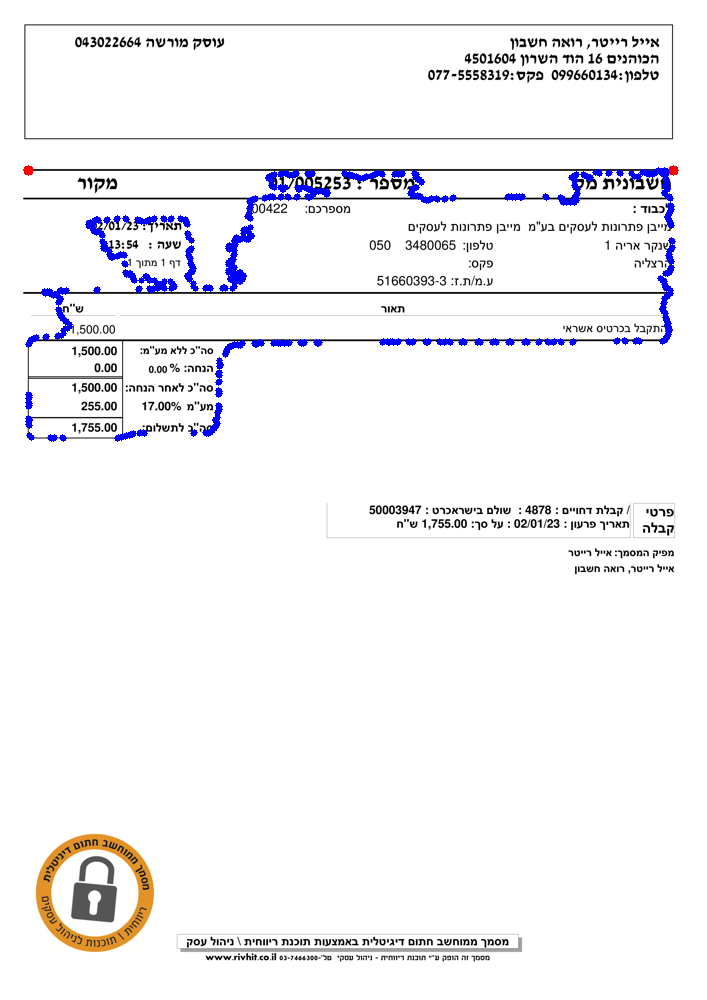

In [160]:
(min_x, max_x), (min_y, max_y), (width,height) = calcBB()
(min_x, max_x), (min_y, max_y), (width,height)
tmpImg = image.copy()
cv2.circle(tmpImg, (min_x,min_y), radius=5, color=(255,0, 0), thickness=-1)  # Red circles
cv2.circle(tmpImg, (max_x,min_y), radius=5, color=(255,0, 0), thickness=-1)  # Red circles

cv2.circle(tmpImg, boundingQuadrilateral[0], radius=5, color=(0, 0,255), thickness=-1)  # Red circles
cv2.circle(tmpImg, boundingQuadrilateral[1], radius=5, color=(0, 0,255), thickness=-1)  # Red circles

for pt in contour:
    cv2.circle(tmpImg, pt[0], radius=3, color=(0, 0,255), thickness=-1)  # Red circles
    
Image.fromarray(tmpImg)

In [161]:
lb,rb,_,_ = boundingQuadrilateral
mask_coords = np.array( [lb,rb])
mask_coords


array([[ 90, 224],
       [664, 172]], dtype=int32)

In [162]:
mask_coords = mask_coords.T
mask_coords

array([[ 90, 664],
       [224, 172]], dtype=int32)

In [163]:
print(mask_coords[0].min())
print(mask_coords[0].max())
print(mask_coords[1].min())
print(mask_coords[1].max())

90
664
172
224


In [164]:
# Get minimum and maximum coordinates from the mask pixels
l, r  = mask_coords[0].min(), mask_coords[0].max()
b, t = mask_coords[1].min()+1, mask_coords[1].max()+1
bbox = [(int(l),int(b)), (int(r), int(t))]
bbox

[(90, 173), (664, 225)]

In [165]:

points = contour.squeeze()
points.shape 

(775, 2)

In [166]:

def find_points_in_bbox(bbox, points):
 """
 Finds all points within a given bounding box.

 Args:
   bbox: A list of two tuples representing the top-left and bottom-right corners of the bounding box.
     Ex: [(left, bottom), (top, right)]
   points: A list of tuples representing the points to check.
     Ex: [(x1, y1), (x2, y2), ...]

 Returns:
   A list of points that are within the bounding box.
 """

 l, b = bbox[0]  # Extract left and bottom coordinates
 r, t = bbox[1]  # Extract top and right coordinates

 points_inside = []
 for x, y in points:
   if l <= x <= r and b <= y <= t:  # Check if point is within bbox boundaries
     points_inside.append((x, y))

 return points_inside

points_inside = find_points_in_bbox(bbox, points)
points_inside.insert(0,bbox[0])
points_inside.insert(-1,bbox[1])
len(points_inside)

243

In [167]:
slopes = []
diff = []
for p1,p2 in zip(points_inside[0:-2],points_inside[1:]):
    x1,y1 = p1
    x2,y2 = p2
    if x1-x2 == 0:
        continue
    slope = (y2-y1)/(x1-x2+1e-16)
    slopes.append(slope)
    diff.append(x1-x2+1e-16)

In [168]:
mean = np.mean(slopes)

# Calculate standard deviation using numpy.std
standard_deviation = np.std(slopes)
mean, standard_deviation

(0.00899740487946301, 0.7256947713429909)

In [169]:
slopes_filtered = [v for v in slopes if abs(v)<=standard_deviation*1.1]

In [170]:
mean2 = np.mean(slopes_filtered)
mean2

0.009331073736561541

In [171]:
calculate_angle(mean2)


0.5346156276524383

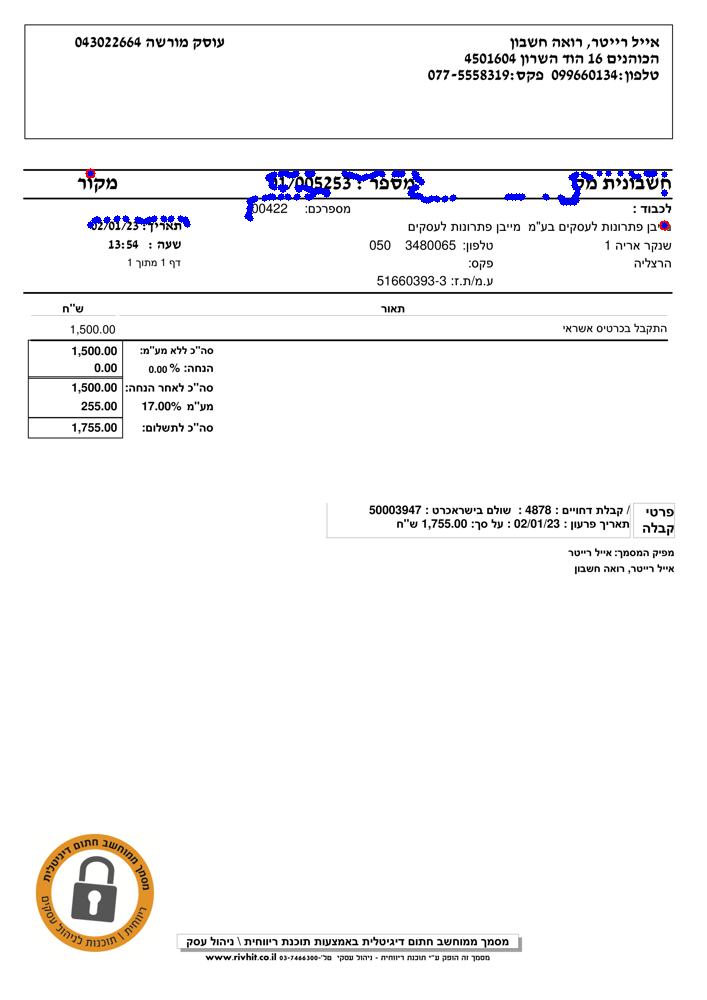

In [172]:
tmpImg = image.copy()
# Iterate through points and draw them on the image
cv2.circle(tmpImg, bbox[0], radius=5, color=(255,0, 0), thickness=-1)  # Red circles
cv2.circle(tmpImg, bbox[1], radius=5, color=(255,0, 0), thickness=-1)  # Red circles
for point in points_inside:
    cv2.circle(tmpImg, point, radius=3, color=(0, 0, 255), thickness=-1)  # Red circles

Image.fromarray(tmpImg)

In [124]:

def find_approximate_line(points_inside):
    """
    Finds the approximate line using linear regression for a given set of points.

    Args:
        points_inside: A list of tuples representing the points to fit the line to.

    Returns:
        A tuple containing the slope and intercept of the estimated line.
    """

    x_vals = [point[0] for point in points_inside]
    y_vals = [point[1] for point in points_inside]

    # Use numpy's polyfit function for linear regression
    slope, intercept = np.polyfit(x_vals, y_vals, 1)

    return slope, intercept

slope, intercept = find_approximate_line(points_inside)

print("Approximate line: y = {}x + {}".format(slope, intercept))

Approximate line: y = -0.0511241183262148x + 210.6807678028373


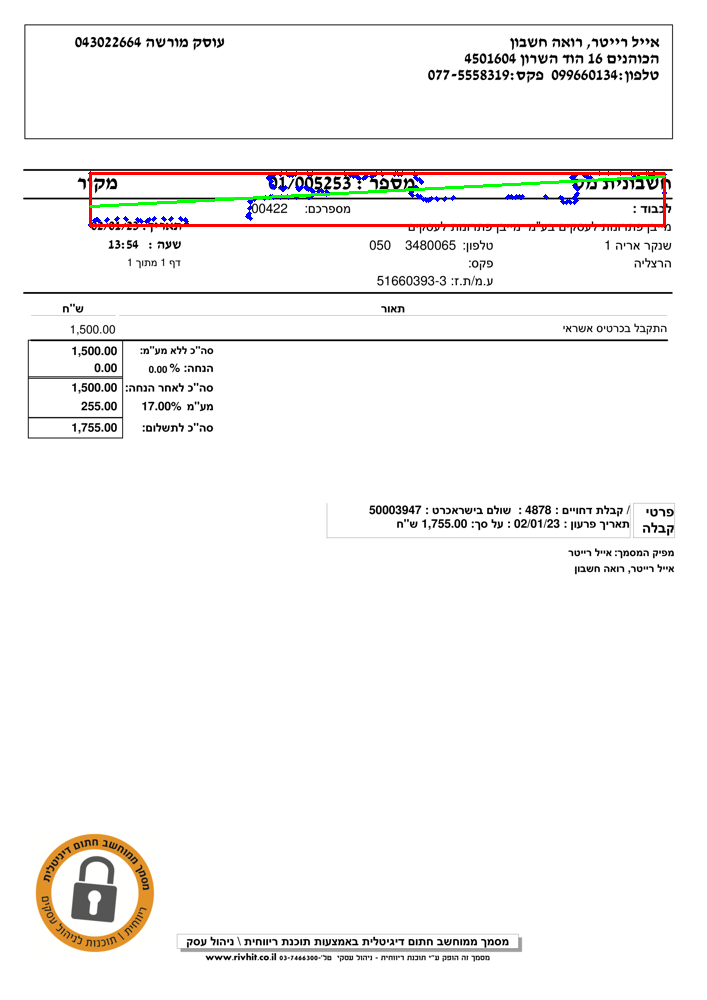

In [125]:

def draw_line_on_image(img, points_inside, bbox):
  """
  Draws the approximate line and bounding box on the image.

  Args:
      img: The image as a NumPy array.
      points_inside: A list of tuples representing points inside the bounding box.
      bbox: A list of two tuples representing the top-left and bottom-right corners of the bounding box.
  """

  # Find approximate line
  slope, intercept = find_approximate_line(points_inside)

  # Calculate line endpoints for visualization (assuming image width is in img.shape[1])
  x1 = bbox[0][0]  # Left edge of bounding box
  y1 = int(slope * x1 + intercept)  # Calculate y-coordinate for x1 using the line equation
  x2 = bbox[1][0]  # Right edge of bounding box
  y2 = int(slope * x2 + intercept)  # Calculate y-coordinate for x2 using the line equation

  # Draw points
  for point in points_inside:
      cv2.circle(img, point, radius=2, color=(0, 0, 255), thickness=-1)  # Red circles

  # Draw bounding box
  cv2.rectangle(img, bbox[0], bbox[1], color=(255, 0, 0), thickness=2)  # Blue rectangle

  # Draw line
  cv2.line(img, (x1, y1), (x2, y2), color=(0, 255, 0), thickness=2)  # Green line

tmpImg = image.copy()
# Draw line and bounding box on the image
draw_line_on_image(tmpImg, points_inside, bbox)

Image.fromarray(tmpImg)

In [126]:
def calculate_angle(slope):
    """
    Calculates the angle of the line relative to the x-axis in degrees.

    Args:
    slope: The slope of the estimated line.

    Returns:
    The angle of the line in degrees.
    """

    # Use arctangent (atan) to find the angle in radians
    radians = np.arctan(slope)

    # Convert radians to degrees
    angle_in_degrees = np.rad2deg(radians)

    return angle_in_degrees
angle = calculate_angle(slope)
angle

-2.9266482165738217

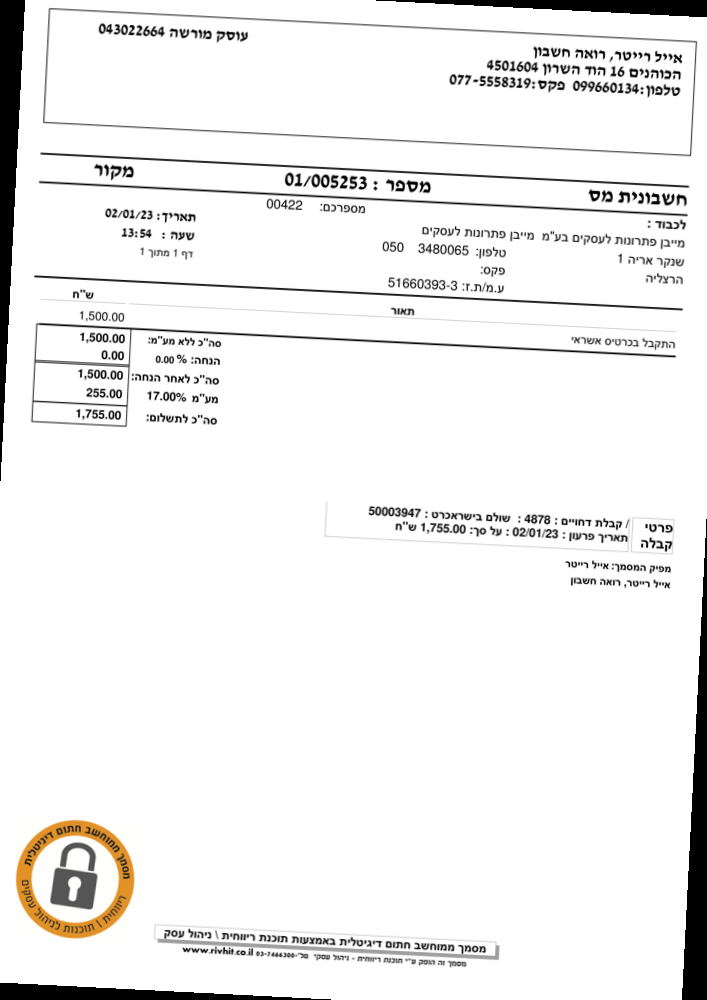

In [127]:
# tmpImg2 = Image.fromarray(tmpImg)
tmpImg2 = Image.fromarray(image.copy())
tmpImg2 =  tmpImg2.rotate(angle, resample=Image.BILINEAR)
tmpImg2

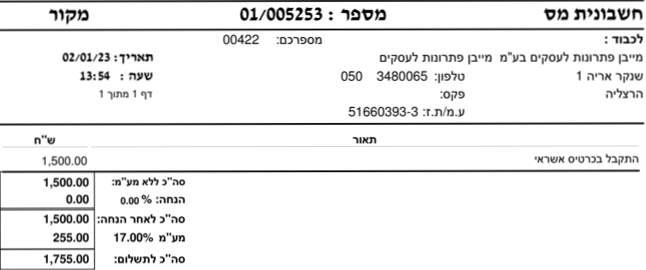

In [101]:
(min_x, max_x), (min_y, max_y), (width,height) = calcBB()

alignTable = tmpImg2.crop([min_x, min_y,max_x, max_y])
alignTable

# Find cell from align tbl

In [39]:
pixel_values = structure_transform(alignTable).unsqueeze(0)
pixel_values = pixel_values.to(device)
print(pixel_values.shape)

torch.Size([1, 3, 417, 1000])


In [40]:
# forward pass
with torch.no_grad():
  outputs = structure_model(pixel_values)

In [41]:
# update id2label to include "no object"
structure_id2label = structure_model.config.id2label
structure_id2label[len(structure_id2label)] = "no object"

cells = outputs_to_objects(outputs, alignTable.size, structure_id2label)
print(cells)

[{'label': 'table column', 'score': 0.9753251671791077, 'bbox': [100.33718872070312, 0.6546058058738708, 216.21820068359375, 252.62863159179688]}, {'label': 'table row', 'score': 0.8736172914505005, 'bbox': [41.184913635253906, 68.1689224243164, 644.1854248046875, 86.34718322753906]}, {'label': 'table spanning cell', 'score': 0.5707411766052246, 'bbox': [40.14189147949219, 6.6487135887146, 101.74552154541016, 110.91756439208984]}, {'label': 'table column', 'score': 0.9245835542678833, 'bbox': [375.98370361328125, 0.9309377670288086, 512.478271484375, 252.82383728027344]}, {'label': 'table column header', 'score': 0.8921836018562317, 'bbox': [40.82126235961914, 0.526496946811676, 644.6735229492188, 112.27140808105469]}, {'label': 'table row', 'score': 0.7911803126335144, 'bbox': [41.69536590576172, 25.769357681274414, 644.0623168945312, 48.56501388549805]}, {'label': 'table column', 'score': 0.9905305504798889, 'bbox': [513.3587646484375, 0.9731703996658325, 644.34326171875, 252.5960083

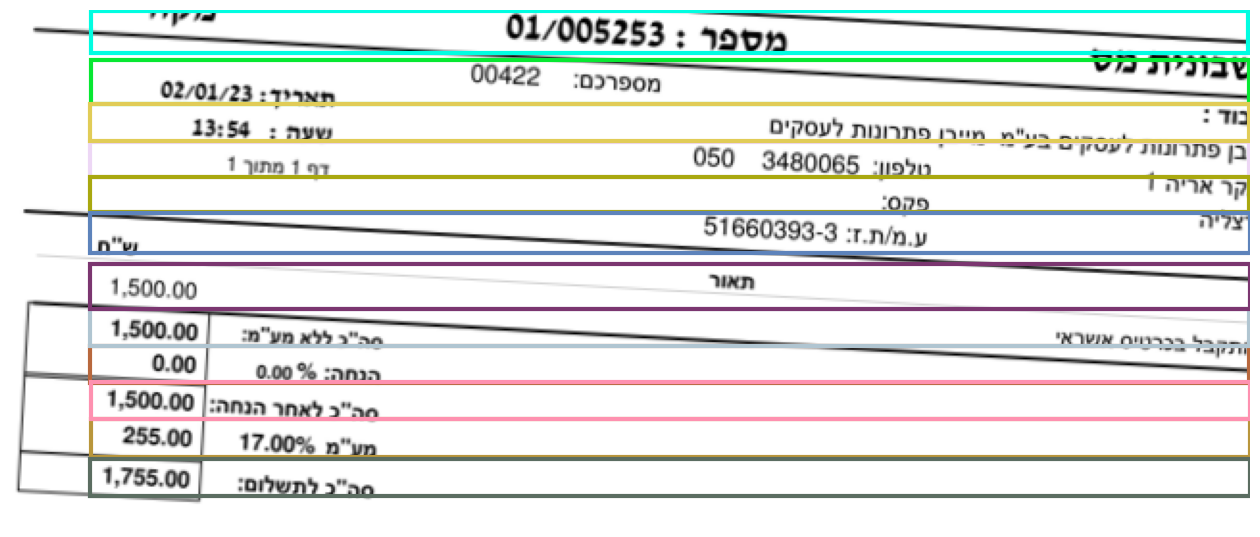

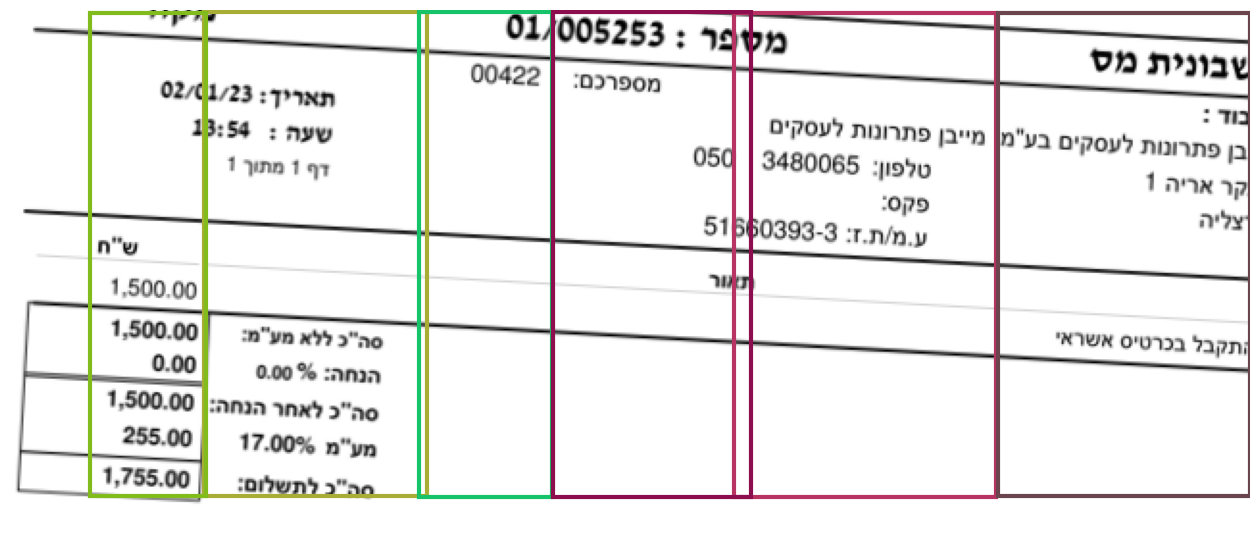

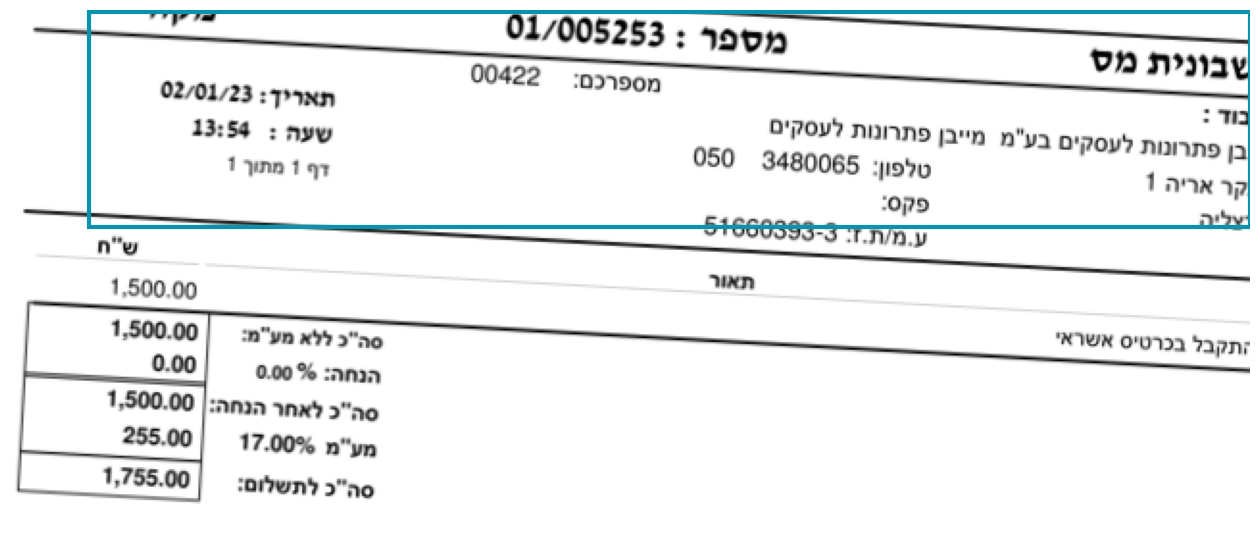

In [42]:
plot_results_cells(alignTable,cells, class_to_visualize="table row")
plot_results_cells(alignTable, cells, class_to_visualize="table column")
plot_results_cells(alignTable,cells, class_to_visualize="table column header")

# Find the inverse homography matrix